# Imports


In [1]:
%load_ext autoreload

In [4]:
%autoreload 2

import functools
import logging
import operator
import socket
from typing import *

import humanize
import numpy as np
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

from tensorflow.keras import optimizers, utils

from tomo2seg.logger import logger

In [5]:
n_gpus = len(tf.config.list_physical_devices('GPU'))

tf_version = tf.__version__
logger.info(f"{tf_version=}")

hostname = socket.gethostname()
logger.info(
    f"Hostname: {hostname}\nNum GPUs Available: {n_gpus}\nThis should be:\n\t"
    + '\n\t'.join(['2 on R790-TOMO', '1 on akela', '1 on hathi', '1 on krilin'])
)

logger.debug(
    "physical GPU devices:\n\t"
    + "\n\t".join(map(str, tf.config.list_physical_devices('GPU'))) + "\n"
    + "logical GPU devices:\n\t"
    + "\n\t".join(map(str, tf.config.list_logical_devices('GPU')))
)

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
gpu_strategy = tf.distribute.MirroredStrategy()
logger.debug(f"{gpu_strategy=}")

INFO::tomo2seg::{<ipython-input-5-70ddb701656b>:<module>:004}::[2020-12-19::16:53:18.332]
tf_version='2.2.0'

INFO::tomo2seg::{<ipython-input-5-70ddb701656b>:<module>:007}::[2020-12-19::16:53:18.334]
Hostname: R7920-tomo
Num GPUs Available: 0
This should be:
	2 on R790-TOMO
	1 on akela
	1 on hathi
	1 on krilin

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


# Model

In [6]:
logger.setLevel(logging.DEBUG)

INFO::tomo2seg::{<ipython-input-32-e908c872a2a1>:<module>:042}::[2020-12-19::17:50:21.939]
Creating the Keras model.

DEBUG::tomo2seg::{modular_unet.py:u_net2halfd_IIencdec:487}::[2020-12-19::17:50:21.941]
dict2str(unet_block_kwargs)="{   'batch_norm': True,\n    'convlayer': <ConvLayer.conv2d: 0>,\n    'dropout': 0,\n    'kernel_size': 3,\n    'res': True,\n    'return_layers': True}"

DEBUG::tomo2seg::{modular_unet.py:u_net2halfd_IIencdec:503}::[2020-12-19::17:50:21.941]
dict2str(unet_down_kwargs)="{   'batchnorm': True,\n    'conv_sampling': True,\n    'convlayer': <ConvLayer.conv2d: 0>,\n    'return_layers': True}"

DEBUG::tomo2seg::{modular_unet.py:u_net2halfd_IIencdec:518}::[2020-12-19::17:50:21.942]
dict2str(unet_up_kwargs)="{   'batchnorm': True,\n    'conv_sampling': True,\n    'convlayer': <ConvLayer.conv2d: 0>,\n    'return_layers': True}"

DEBUG::tomo2seg::{modular_unet.py:u_net2halfd_IIencdec:526}::[2020-12-19::17:50:21.943]
nlayers=5

DEBUG::tomo2seg::{modular_unet.py:u_n

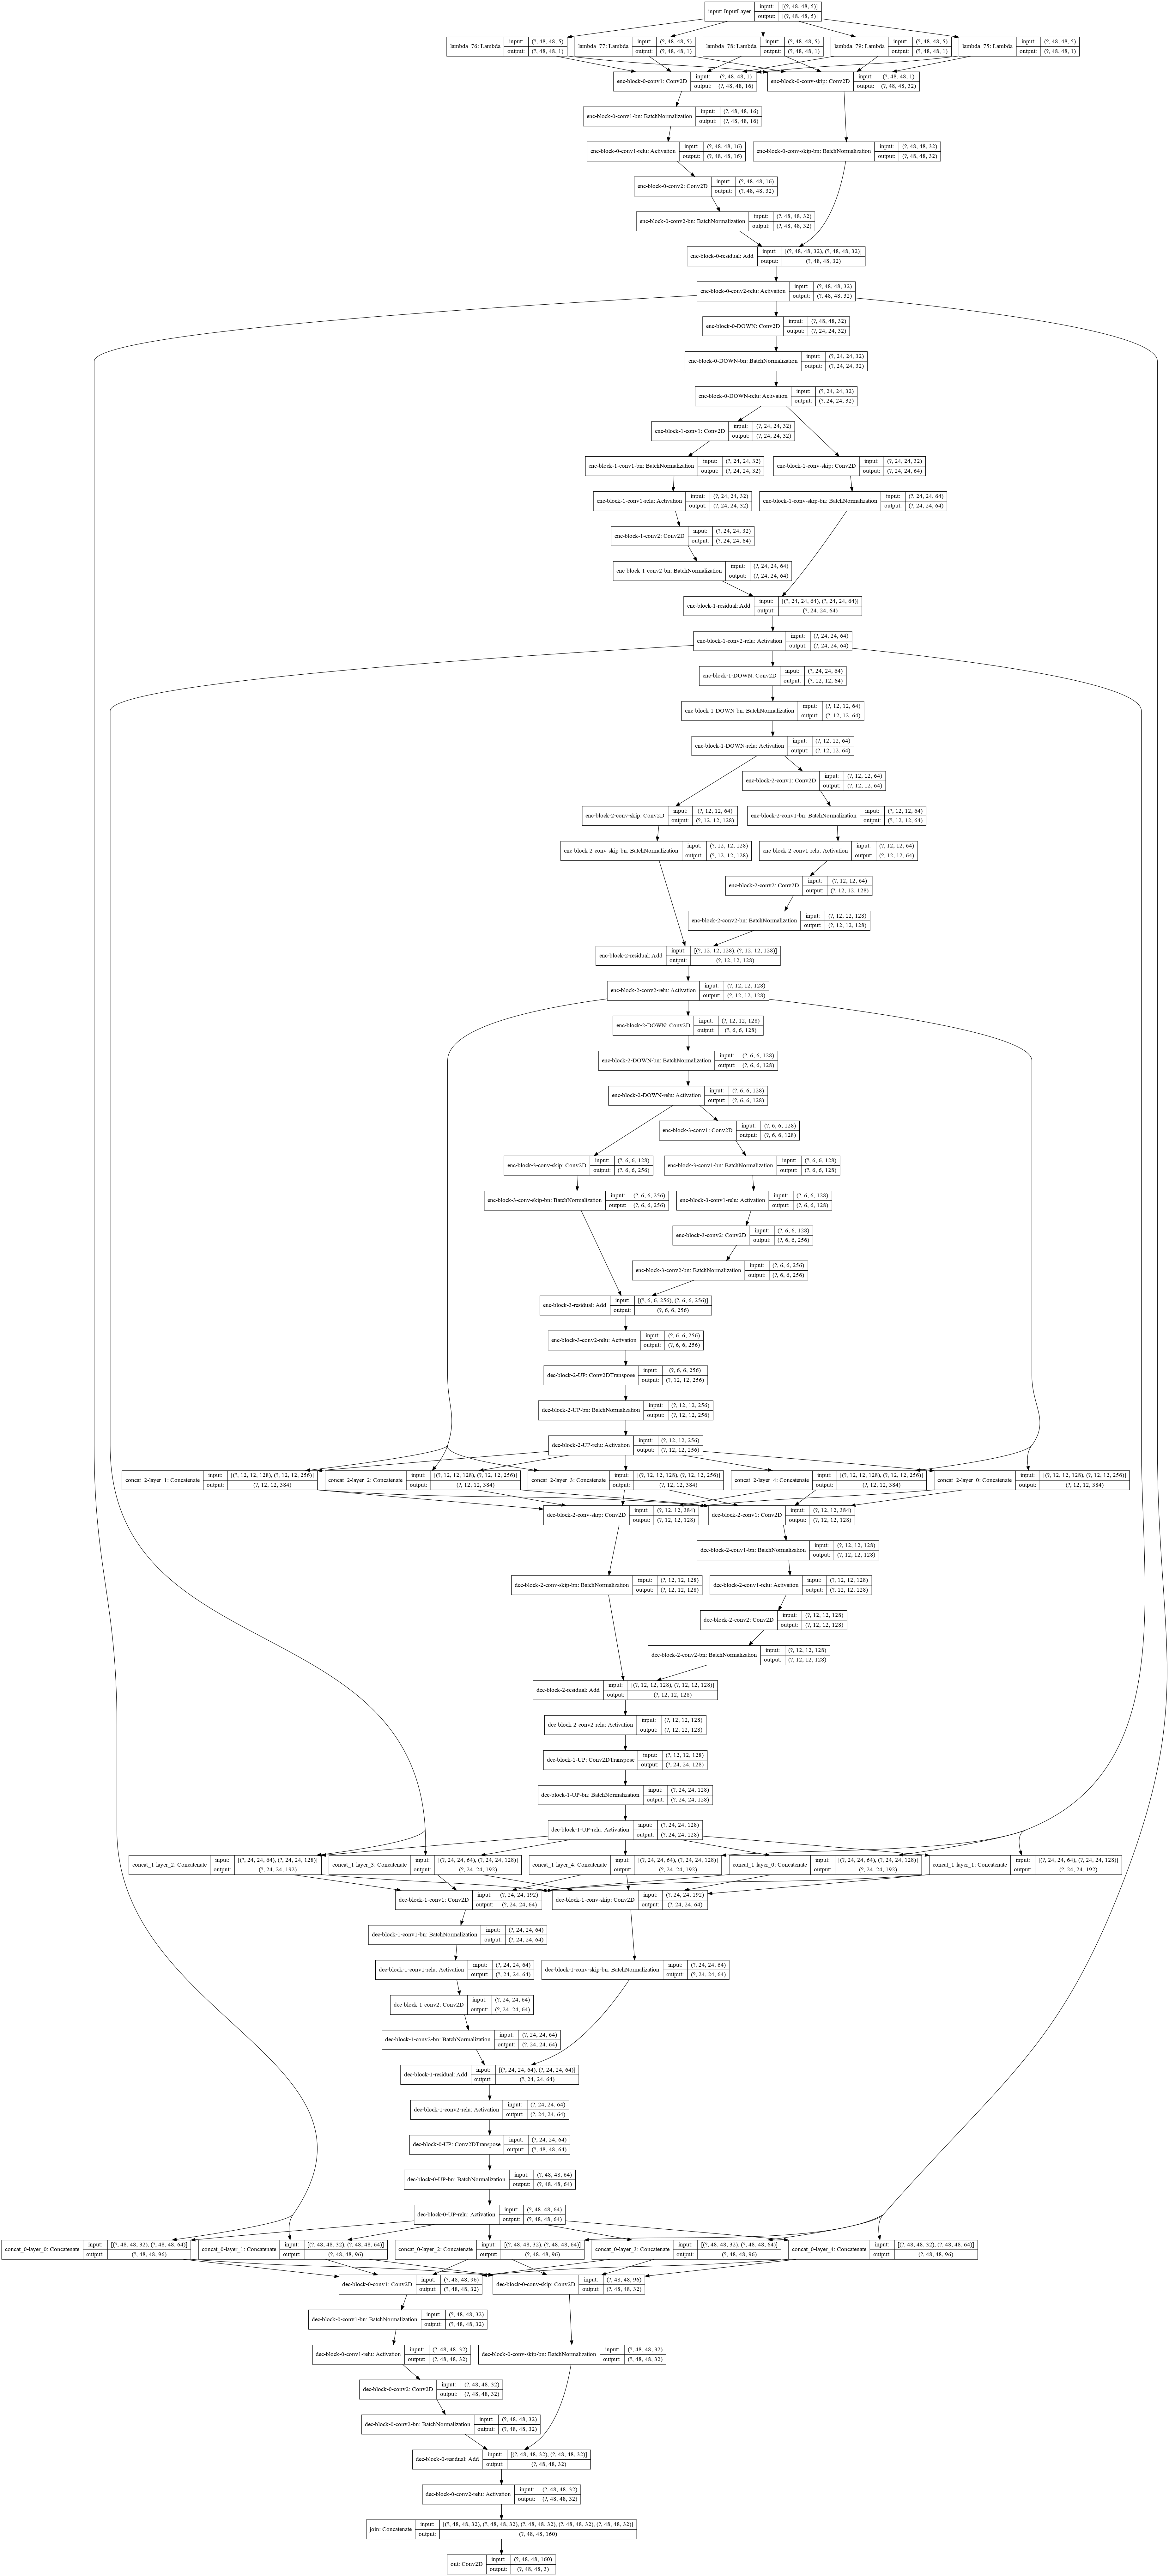

In [32]:
%autoreload 2

from tomo2seg import (
    losses as tomo2seg_losses,
    
    modular_unet,
    utils as tomo2seg_utils,
)
from tomo2seg.logger import logger

# 176/288 is the biggest that covers the whole validation shape
# it's kind of stupid that i'm limited by that...
crop_shape = (48, 48, 5)  # multiple of 16 (requirement of a 4-level u-net)

model_master_name = "unet2halfd"
model_version = "II-enc-scratch"

model_is_2halfd = True
model_is_2d = False

n_classes = 3

# model_factory_function = modular_unet.u_net
model_factory_function = modular_unet.u_net2halfd_IIencdec
model_factory_kwargs = {
    **modular_unet.kwargs_IIencdec03,
#     **modular_unet.kwargs_IIencdec03_debug,
    **dict(
        convlayer=modular_unet.ConvLayer.conv2d,
        input_shape=crop_shape,
        output_channels=n_classes,
#         nb_filters_0=2,
        #         nb_filters_0 = 4,
#                 nb_filters_0 = 8,
#                 nb_filters_0 = 10,
#                 nb_filters_0 = 12,
                nb_filters_0 = 16,
        #         nb_filters_0 = 32,
    ),
}

logger.info("Creating the Keras model.")

# with gpu_strategy.scope():

model = model_factory_function(
    name="unet2halfd-better",
    **model_factory_kwargs
)

loss = tomo2seg_losses.jaccard2_flat
optimizer = optimizers.Adam(lr=.003)

model.compile(loss=loss, optimizer=optimizer)

utils.plot_model(model, show_shapes=True)

In [31]:
model.summary()

Model: "unet2halfd-better"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 48, 48, 5)]  0                                            
__________________________________________________________________________________________________
lambda_70 (Lambda)              (None, 48, 48, 1)    0           input[0][0]                      
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 48, 48, 1)    0           input[0][0]                      
__________________________________________________________________________________________________
lambda_72 (Lambda)              (None, 48, 48, 1)    0           input[0][0]                      
__________________________________________________________________________________

In [ ]:
model_internal_nvoxel_factor = tomo2seg_utils.get_model_internal_nvoxel_factor(model)

logger.debug(f"{model_internal_nvoxel_factor=}")